**STATISTICAL LEARNING AND NEURAL NETWORKS, A.A. 2022/2023**

**COMPUTER LAB 4** - Kalman filter

**Duration: 3 hours**

**Introduction:**

In this lab, you are provided with the set of coordinates (x,y – horizontal and vertical) describing the trajectories of pedestrians moving acrooss a scene. Your task is to simulate the observed positions of the pedestrians by adding observation noise, then to track the subjects using a Kalman filter. In other words, you need to estimate the next (x,y) positions, from the observations of the previous positions.


*Simulating the observed coordinates*

Choose one of the trajectories in the dataset. This data will be considered the real trajectory. Generate the observed directory by adding observation noise $\delta_t \sim\ \mathcal{N}(0,\sigma^{2}_{R})\$ to the (x,y) coordinates.


*Designing the Kalman filter*

Your task is to **design a Kalman filter** based on a constant velocity model, which tracks the next (x,y) position of the object, from the observation of the previous positions. The code must be based on the following model.

*   The state vector contains coordinates and velocities: $z^{T}_{t} = (z_{1t}, z_{2t}, v_{1t}, v_{2t})$ (see slides). The object has initial coordinates (0,0) and velocity $(\Delta,Δ)$.
*   Only the coordinates (but not the velocities) are observed. This leads to a linear dynamical system with:

$A = \left( \begin{matrix} 1 & 0 & \Delta & 0 \\ 0 & 1 & 0 & \Delta \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$


$C = \left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{matrix} \right)$

and B = D = 0.

*   $\Sigma_{Q}$, and $\Sigma_{R}$ should be set to:

$\Sigma_{Q} = \sigma^{2}_{Q}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

$\Sigma_{R} = \sigma^{2}_{R}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

To see if your Kalman filter is working well, you should plot the estimated position of the object over time with respect to the true position (i.e., the first two entries of the state vector) and the observed position. Depending on the chosen parameters, for each coordinate the graph may look something like this:

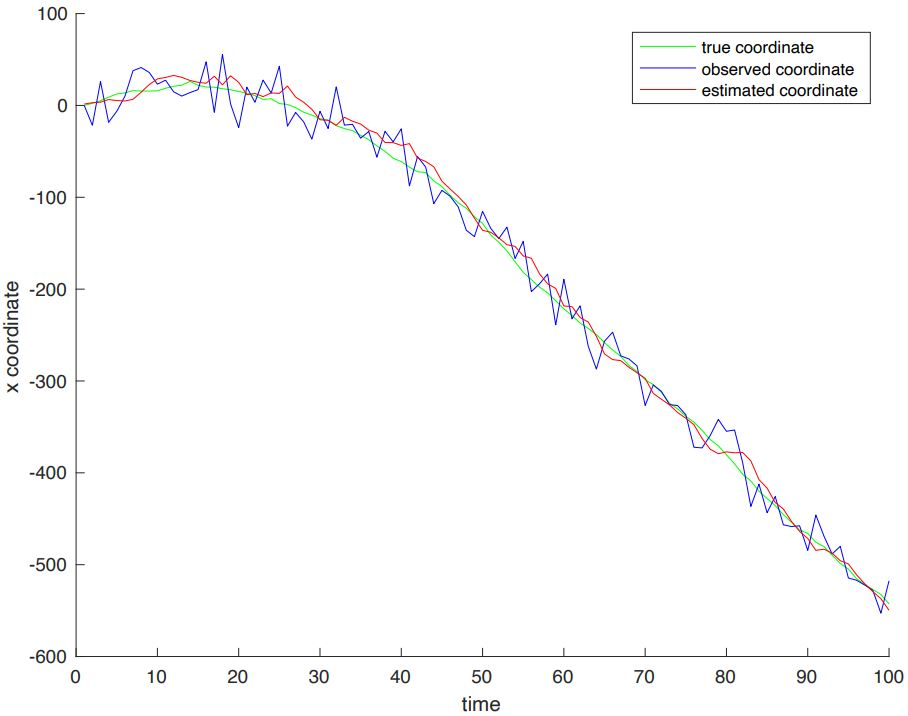

**Suggestion**: when implementing your Kalman filter, you will have to choose initial values for **$\mu_{t}$** and **$\Sigma_{t}$**. Provided that you do not make very unreasonable assumptions, the Kalman filter will update those estimates from observed data, so the initial choices are not very critical. 

Test your Kalman filter modifying the values of some of the parameters, including standard deviations **$\sigma_{Q}$** and **$\sigma_{R}$**, initial values for **$\mu_{t}$** and **$\Sigma_{t}$** and the value of **$\Delta$**.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# ٪pip install ndjson

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import ndjson
import pandas as pd
import numpy as np

#Dataset origin: https://paperswithcode.com/dataset/trajnet-1
#The crowds_students001 file is loaded, and formatted as a list of numpy vectors

with open('crowds_students001_trackonly.ndjson') as f:
  data = ndjson.load(f)

p='-1'

person_dict = []

for ii in range(len(data)):
  if(p!=data[ii]['track']['p']):
    p=data[ii]['track']['p']
    person_dict.append([])
  person_dict[p].append((data[ii]['track']['x'],data[ii]['track']['y']))

person_dict_numpy = []
for ii in range(148):
  person_dict_numpy.append(np.array(person_dict[ii], dtype=float))
# print(person_dict_numpy)
# print(len(person_dict_numpy))


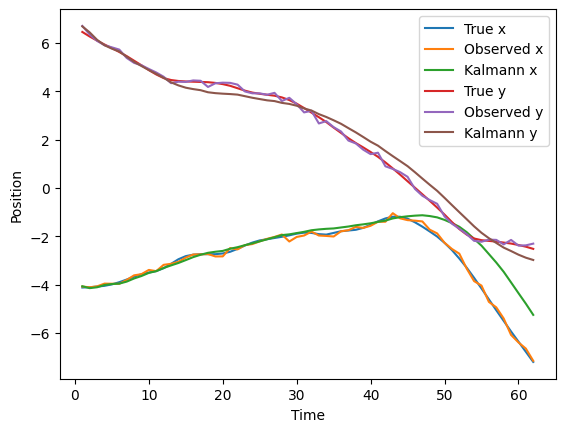

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Implement the kalman filter as a function using the numpy library, the matrix products can be done using the np.dot function
# The matrix inversion can be done using the np.linalg.inv    

def kalman_filter(y, mu_tmin1, sigma_tmin1, A, C, Q, R):
  # Predict the state at the next time step
  mu_tilde = np.dot(A, mu_tmin1) # (4x4) * (4x1) = (4x1)
  sigma_tilde = np.dot(np.dot(A, sigma_tmin1), A.T) + Q # (4x4) * (4x4) * (4x4) = (4x4)
  y_hat = np.dot(C, mu_tilde) # (2x4) * (4x1) = (2x1)

  # Calculate the Kalman gain
  S = np.dot(np.dot(C, sigma_tilde), C.T) + R # (2x4) * (4x4) * (4x2) + (2x2) = (2x2)
  K = np.dot(np.dot(sigma_tilde, C.T), np.linalg.inv(S)) # (4x4) * (4x2) * (2x2) = (4x2)
  
  # Update the estimate of the state
  #r = np.subtract(y, y_hat)
  y = y.reshape(-1, 1) # reshape y to be a column vector (2x1) instead of a row vector (1x2) | same as y = y[:, np.newaxis] and y = y.T
  mu_est = mu_tilde + np.dot(K, (y - y_hat)) # (4x1) + (4x2) * (2x1) = (4x1)
  sigma_est = np.dot((np.eye(4) - np.dot(K, C)), sigma_tilde) # (4x4) - (4x2) * (2x4) * (4x4) = (4x4)

  return mu_est, sigma_est

true_positions = person_dict_numpy[69] #choose a single trajectory by taking an element of the list person_dict_numpy, select a random index between 0 and 148  

#Define parameter delta
Delta = 1

A = np.array([[1, 0, Delta, 0],
             [0, 1, 0, Delta],
             [0, 0, 1, 0 ],
             [0, 0, 0, 1 ]])


# Define the measurement matrix
C = np.array([[1, 0, 0, 0],  # x is measured directly
             [0, 1, 0, 0]]) # y is measured directly

# Set the standard deviation of the measurement noise

sigma_R = 0.1
sigma_Q = 0.001

# Define the process noise covariance matrix
Q = (sigma_Q**2)*np.eye(4) # 4x4

# Define the measurement noise covariance matrix
R = (sigma_R**2)*np.eye(2) # 2x2

# Set the initial state and covariance
mu_0 = np.array([[0.1,0.03,0.1,0.9]]).T # 4x1
sigma_0 = [1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1] # 4x4

# Iterate over the observed coordinates
y_est = []
y_est.append((mu_0, sigma_0))


#data initialization
TSeries = []
XKalman = []
YKalman = []
XObs = []
YObs = []
XTrue = []
YTrue = []

for t in range(1,len(true_positions)):
  # Get the observed coordinates at time t 
  # Note: the observed position is simulated by adding gaussian noise to the true_positions
  y = true_positions[t] + np.random.normal(0,sigma_R,2)
  
  #apply the kalman filter on the observed coordinates 
  y_est.append(kalman_filter(y, y_est[t-1][0], y_est[t-1][1], A, C, Q, R))
  XKalman.append(y_est[t][0][0]) # x coordinate
  YKalman.append(y_est[t][0][1]) # y coordinate
  TSeries.append(t)
  XObs.append(y[0])
  YObs.append(y[1])
  XTrue.append(true_positions[t][0])
  YTrue.append(true_positions[t][1])

#Plot the trajectory of the x coordinate over time and the trajectory of the y coordinate over time into two separate plot
plt.plot(TSeries, XTrue, label='True x')
plt.plot(TSeries, XObs, label='Observed x')
plt.plot(TSeries, XKalman, label='Kalmann x')
plt.plot(TSeries, YTrue, label='True y')
plt.plot(TSeries, YObs, label='Observed y')
plt.plot(TSeries, YKalman, label='Kalmann y')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.show()


#Use the matplotlib library to plot the true positions, observed positions y and the results of the kalman filtering
#You should obtain a plot which resembles the one in the figure 
#Plot the trajectory of the x coordinate over time and the trajectory of the y coordinate over time into two separate plot